In [1]:
# %%
import os
import sys
import torch
import numpy as np
import librosa
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ASTForAudioClassification, ASTFeatureExtractor
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

/Users/jaewone/ENTER/envs/tf24/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# %%
# Settings: target animal and data path
target_animal = 'dog'  # 'cat' or 'dog'

# Set paths
main_path = os.path.join(os.getcwd().rsplit(
    'FurEmotion-AI')[0], 'FurEmotion-AI')
data_path = os.path.join(main_path, 'data', target_animal)

sys.path.append(main_path)

if not os.path.exists(data_path):
    raise ValueError(f'No such animal data path: {data_path}')

state_list = [dir_path for dir_path in os.listdir(
    data_path) if os.path.isdir(os.path.join(data_path, dir_path))]
print(f"List of states to classify: {state_list}")

num_classes = len(state_list)

List of states to classify: ['brushing', 'isolation', 'food']


In [3]:
# Collect data and labels
data = []
labels = []

for idx, state in enumerate(state_list):
    state_path = os.path.join(data_path, state)
    for root, dirs, files in os.walk(state_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                # Load audio file
                wave, sr = librosa.load(file_path, mono=True, sr=16000)
                data.append(wave)
                labels.append(idx)

# %%
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42)

In [4]:
# Load feature extractor
feature_extractor = ASTFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593")

# Create custom dataset


class AudioDataset(Dataset):
    def __init__(self, audio_list, labels, feature_extractor):
        self.audio_list = audio_list
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.audio_list)

    def __getitem__(self, idx):
        audio = self.audio_list[idx]
        label = self.labels[idx]
        # Process audio
        inputs = self.feature_extractor(
            audio, sampling_rate=16000, return_tensors="pt", padding=True)
        return {
            'input_values': inputs['input_values'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Create datasets and dataloaders
train_dataset = AudioDataset(X_train, y_train, feature_extractor)
test_dataset = AudioDataset(X_test, y_test, feature_extractor)

batch_size = 4  # Adjust based on your GPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Iterate over the train_loader and print the shapes of the first batch
for batch in train_loader:
    input_values = batch['input_values']
    labels = batch['labels']

    # e.g., torch.Size([4, 1024])
    print(f"input_values shape: {input_values.shape}")
    # e.g., torch.Size([4])
    print(f"labels shape: {labels.shape}")
    break

input_values shape: torch.Size([4, 1024, 128])
labels shape: torch.Size([4])


In [5]:
# Load model
from transformers import ASTForAudioClassification

model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Update the model's config to reflect the new number of labels
model.config.num_labels = num_classes

# Re-initialize the classifier's output projection layer
model.classifier.out_proj = torch.nn.Linear(
    model.config.hidden_size, num_classes)

In [6]:
# Set up optimizer and scheduler
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

In [7]:
# Training loop with Early Stopping
from sklearn.metrics import accuracy_score

train_losses = []
train_accuracies = []
val_accuracies = []

# Early Stopping parameters
patience = 10  # Number of epochs to wait for improvement
best_val_acc = 0.0
epochs_no_improve = 0
early_stop = False
best_model_path = os.path.join(main_path, 'model', 'best_model.pth')

for epoch in range(epochs):
    if early_stop:
        print("Early stopping triggered. Stopping training.")
        break

    print(f"\nEpoch {epoch+1}/{epochs}")
    model.train()
    epoch_loss = 0
    true_labels = []
    pred_labels = []
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_values=input_values, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    avg_loss = epoch_loss / len(train_loader)
    acc = accuracy_score(true_labels, pred_labels)
    train_losses.append(avg_loss)
    train_accuracies.append(acc)
    print(f"Training loss: {avg_loss:.4f}, Training accuracy: {acc:.4f}")

    # Validation after each epoch
    model.eval()
    val_true_labels = []
    val_pred_labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_values=input_values)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=-1)
            val_true_labels.extend(labels.cpu().numpy())
            val_pred_labels.extend(preds.cpu().numpy())
    val_acc = accuracy_score(val_true_labels, val_pred_labels)
    val_accuracies.append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}")

    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        print(
            f"Validation accuracy improved to {best_val_acc:.4f}. Saving model.")
    else:
        epochs_no_improve += 1
        print(
            f"No improvement in validation accuracy for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            early_stop = True

# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.to(device)
print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")


Epoch 1/10


Training: 100%|██████████| 88/88 [11:13<00:00,  7.66s/it]


Training loss: 1.1092, Training accuracy: 0.5483


Validation: 100%|██████████| 22/22 [00:56<00:00,  2.57s/it]


Validation accuracy: 0.7614
Validation accuracy improved to 0.7614. Saving model.

Epoch 2/10


Training: 100%|██████████| 88/88 [11:24<00:00,  7.78s/it]


Training loss: 0.5986, Training accuracy: 0.7386


Validation: 100%|██████████| 22/22 [00:55<00:00,  2.54s/it]


Validation accuracy: 0.7727
Validation accuracy improved to 0.7727. Saving model.

Epoch 3/10


Training: 100%|██████████| 88/88 [11:13<00:00,  7.65s/it]


Training loss: 0.2841, Training accuracy: 0.9091


Validation: 100%|██████████| 22/22 [00:55<00:00,  2.52s/it]


Validation accuracy: 0.6136
No improvement in validation accuracy for 1 epoch(s).

Epoch 4/10


Training: 100%|██████████| 88/88 [11:15<00:00,  7.68s/it]


Training loss: 0.0729, Training accuracy: 0.9744


Validation: 100%|██████████| 22/22 [00:55<00:00,  2.50s/it]


Validation accuracy: 0.8182
Validation accuracy improved to 0.8182. Saving model.

Epoch 5/10


Training: 100%|██████████| 88/88 [11:07<00:00,  7.59s/it]


Training loss: 0.0375, Training accuracy: 0.9943


Validation: 100%|██████████| 22/22 [00:55<00:00,  2.52s/it]


Validation accuracy: 0.6932
No improvement in validation accuracy for 1 epoch(s).

Epoch 6/10


Training: 100%|██████████| 88/88 [11:09<00:00,  7.61s/it]


Training loss: 0.0076, Training accuracy: 1.0000


Validation: 100%|██████████| 22/22 [00:55<00:00,  2.52s/it]


Validation accuracy: 0.7955
No improvement in validation accuracy for 2 epoch(s).

Epoch 7/10


Training: 100%|██████████| 88/88 [11:07<00:00,  7.58s/it]


Training loss: 0.0012, Training accuracy: 1.0000


Validation: 100%|██████████| 22/22 [00:54<00:00,  2.50s/it]


Validation accuracy: 0.7614
No improvement in validation accuracy for 3 epoch(s).

Epoch 8/10


Training: 100%|██████████| 88/88 [11:09<00:00,  7.61s/it]


Training loss: 0.0009, Training accuracy: 1.0000


Validation: 100%|██████████| 22/22 [00:55<00:00,  2.50s/it]


Validation accuracy: 0.7614
No improvement in validation accuracy for 4 epoch(s).

Epoch 9/10


Training: 100%|██████████| 88/88 [11:08<00:00,  7.60s/it]


Training loss: 0.0008, Training accuracy: 1.0000


Validation: 100%|██████████| 22/22 [00:54<00:00,  2.48s/it]


Validation accuracy: 0.7614
No improvement in validation accuracy for 5 epoch(s).

Epoch 10/10


Training: 100%|██████████| 88/88 [11:00<00:00,  7.51s/it]


Training loss: 0.0008, Training accuracy: 1.0000


Validation: 100%|██████████| 22/22 [00:54<00:00,  2.47s/it]

Validation accuracy: 0.7614
No improvement in validation accuracy for 6 epoch(s).
Loaded best model with validation accuracy: 0.8182



/var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/ipykernel_6018/3956621288.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_

In [8]:

# Evaluation on test set
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_values=input_values)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=-1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

acc = accuracy_score(true_labels, pred_labels)
print(f"\nTest Accuracy: {acc:.4f}")

cm = confusion_matrix(true_labels, pred_labels)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=state_list))

100%|██████████| 22/22 [00:46<00:00,  2.13s/it]


Test Accuracy: 0.8182

Confusion Matrix:
[[30  2  2]
 [ 3 33  2]
 [ 5  2  9]]

Classification Report:
              precision    recall  f1-score   support

    brushing       0.79      0.88      0.83        34
   isolation       0.89      0.87      0.88        38
        food       0.69      0.56      0.62        16

    accuracy                           0.82        88
   macro avg       0.79      0.77      0.78        88
weighted avg       0.82      0.82      0.81        88



In [ ]:

# Save the model
model_dir = os.path.join(
    main_path, 'model', f'ast_model_pytorch_{target_animal}')
os.makedirs(model_dir, exist_ok=True)
model.save_pretrained(model_dir)
feature_extractor.save_pretrained(model_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


['/Users/jaewone/Downloads/FurEmotion-AI/model/ast_model_pytorch_cat/preprocessor_config.json']

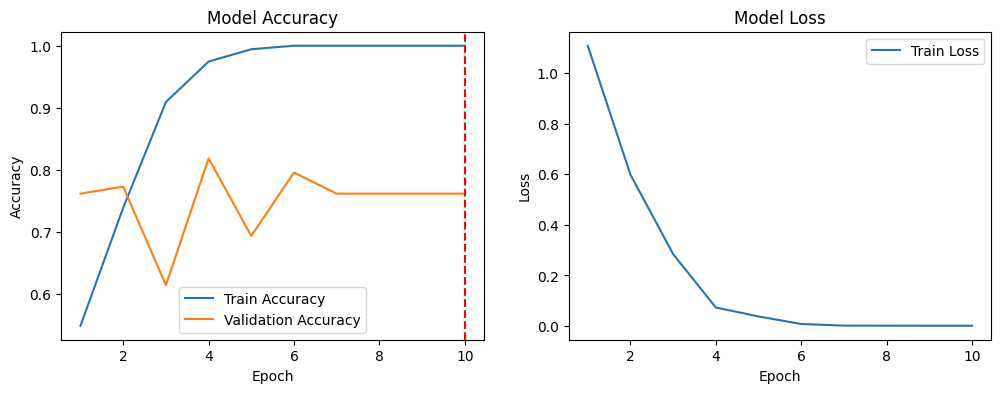

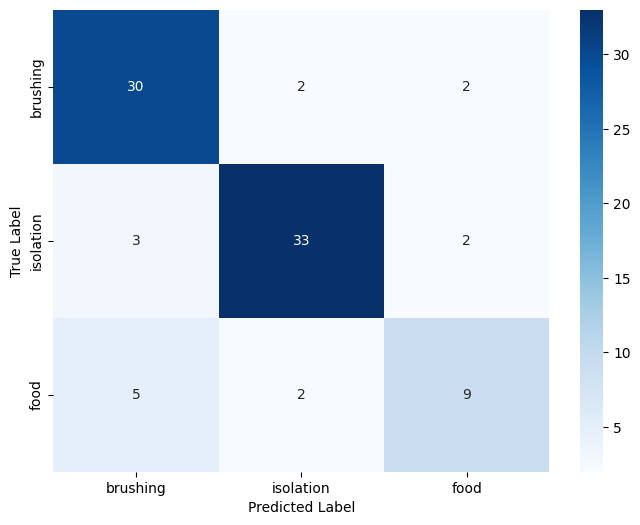

In [11]:
end_epochs = 10

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1),
         train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1),
         val_accuracies, label='Validation Accuracy')
plt.axvline(len(train_accuracies), color='r', linestyle='--',
            label='Early Stopping Point' if early_stop else '')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(range(1, end_epochs + 1), train_losses, label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=state_list, yticklabels=state_list)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()